In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

In [0]:
df = pd.read_csv('/content/drive/My Drive/cleanAccDrugDeaths.csv', index_col=0)

In [46]:
df.head()

,Date,Age,Sex,Race,City of Death,County of Death,Location,COD,Heroin,Cocaine,Fentanyl,Fentanyl Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphetamine,Tramadol,Morphine,Hydromorphone,Other,OpiateNOS,Any Opioid,MannerofDeath
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
14-0273,06/28/2014,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Acute Intoxication,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,Accident
13-0102,03/21/2013,48.0,Male,Black,Norwalk,Fairfield,Hospital,Intoxication,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Accident
16-0165,03/13/2016,30.0,Female,White,Danbury,Unknown,Hospital,Acute Intoxication,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Accident
16-0208,03/31/2016,23.0,Male,White,Greenwich,Unknown,Hospital,Acute Intoxication,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Accident
13-0052,02/13/2013,22.0,Male,Asian,Greenwich,Fairfield,Hospital,Intoxication,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Accident


Let's begin with a histogram of the deaths for each drug.

In [0]:
drug_cols = df.columns[8:25]
drug_names, drug_counts = [], []

for drug in drug_cols:
  drug_names.append(drug)
  drug_counts.append(df[drug].sum())

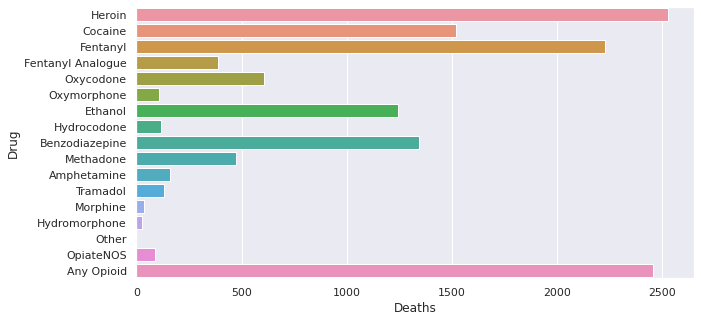

In [48]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x=drug_counts, y=drug_names)
ax.set(xlabel='Deaths',ylabel='Drug')
plt.show()

Let us reorder this so we plot in order of descending number of deaths.

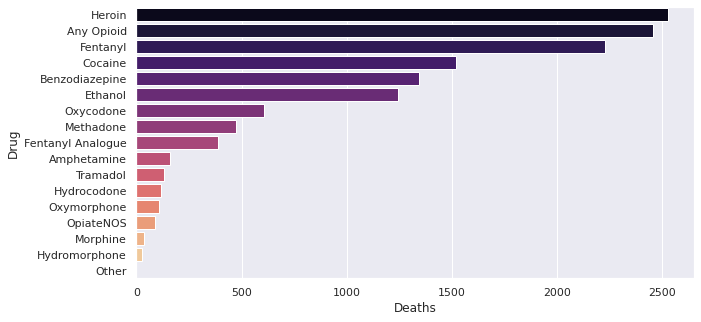

In [151]:
sorted_drugs = []
sorted_death_count = []

for deaths in sorted(drug_counts):
  sorted_drugs.append(drug_names[drug_counts.index(deaths)])
  sorted_death_count.append(deaths)

sorted_drugs.reverse()
sorted_death_count.reverse()

sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x=sorted_death_count, y=sorted_drugs, palette='magma')
ax.set(xlabel='Deaths',ylabel='Drug')
plt.show()

Heroin and Fentanyl dominate the accidental drug related deaths, followed by cocaine, benzodiaepines and then alcohol (Ethanol)! Below we will dislay their respective dominance over the deaths.

In [0]:
def get_dominance(drug):
  global df, drug_counts, drug_names
  return drug_counts[drug_names.index(drug)]/len(df.index)

In [0]:
top5 = ['Heroin', 'Fentanyl', 'Cocaine', 'Benzodiazepine', 'Ethanol']
top5_doms = [get_dominance(drug)*100 for drug in top5]

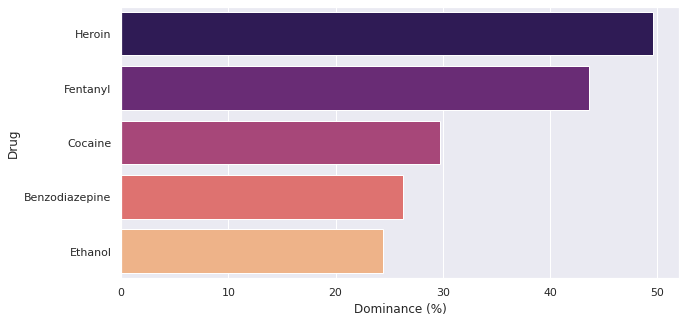

In [155]:
ax = sns.barplot(x=top5_doms, y=top5, palette='magma')
ax.set(xlabel='Dominance (%)', ylabel='Drug')
plt.show()

Heroin was in the bloodstream of nearly half of all the deceased, followed closely by Fentanyl. Alcohol and Benzodiazepines are involved in almost a quarter of the deaths as well. These results give a clear indication of which substances are an issue - Opioids, Benzos and Alcohol are all depressants, with the only stimulant appearing in the top 5 being cocaine.

An issue in the data presents itself with the above chart, notice the `Any Opioid` column? Heroin is an opioid, but the `Any Opioid` class contains less deaths than the `Heroin` column. This is clearly the result of missing data, when the death was logged, someone may have forgotten to flag certain opioid deaths under the `Any Opioid` column. With this in mind we will drop the column for the remainder of the visualisations.

It would be interesting to see the relationship between Sex and deaths, and if any drug is preferred by either sex. I suspect Males will account for the majority of overdoses.

In [0]:
drug_names = []
drug_counts = [] # M/F
s_store = []
min_store = [] # M/F
max_store = [] # M/F

for drug in drug_cols:
  drug_names.extend([drug]*2)
  drug_counts.extend([df.loc[df['Sex']=='Male', drug].sum(),
                      df.loc[df['Sex']=='Female', drug].sum()])
  s_store.extend(['Male','Female'])
  min_store.extend([df.loc[(df['Sex']=='Male') & (df[drug]==1), 'Age'].min(),
                    df.loc[(df['Sex']=='Female') & (df[drug]==1), 'Age'].min()])
  max_store.extend([df.loc[(df['Sex']=='Male') & (df[drug]==1), 'Age'].max(),
                    df.loc[(df['Sex']=='Female') & (df[drug]==1), 'Age'].max()])
  

df_death_sex_split = pd.DataFrame({'Drug':drug_names, 
                             'Deaths':drug_counts, 
                             'Sex':s_store,
                             'Min Age':min_store,
                             'Max Age':max_store})

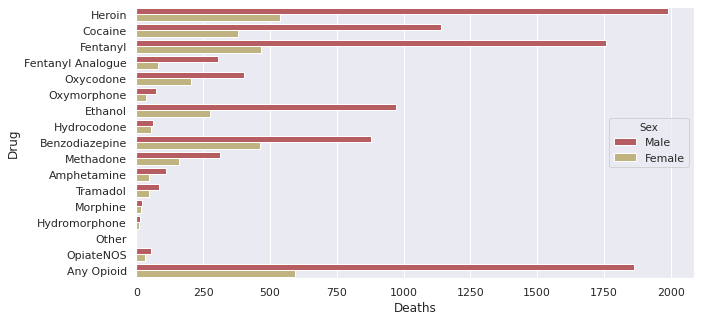

In [157]:
ax = sns.barplot(x='Deaths', y='Drug', hue='Sex', 
                 data=df_death_sex_split, palette=['r','y'])

# palette accepts a color_palette or a list of colors for different levels of hue

Males indeed dominate the deaths, with over 3x the number of deaths compared to females due to certain drugs such as Heroin, Ethanol and Fentanyl. Not a single drug class contains more female deaths than males deaths, with the smallest difference being around 50% in the cases of Oxycodone, Benzodiapines and Methadone.

We can now see the predominant drug issue results from Males abusing Opioids.

Let us now investigate the relationship between age and deaths to determine if it is primarily younger or older people overdosing. I would hypothesise there will be more deaths within the younger generations. We will use a violin plot for this, it is essentially a box plot with a probability distribution.

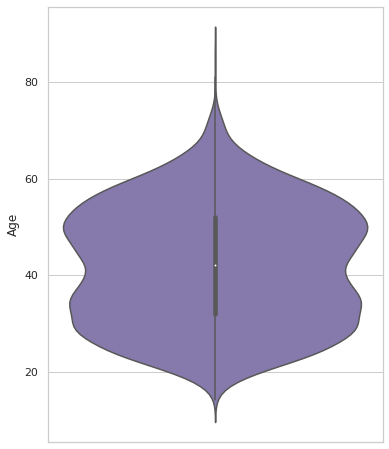

In [158]:
sns.set(rc={'figure.figsize':(6,8)}, style='whitegrid')
ax = sns.violinplot( y='Age', data=df, color='m')

We can see there is a very wide range in the ages of overdoses, beginning in the early teens and ending in the late 80s. However, we can see the majority of overdoses occur between the mid 20s to 60s. 

There are two distinct peaks in the data, occuring around the age of 30, and the age of 50, with a decline in overdoses recorded at the age of 40. 

This is interesting as we expected there to be more deaths among younger people, but it would appear that the majority of drug deaths occur during middle age, followed closely by the younger generation.

Let us now look at the distribution of deaths by age between Males and Females.

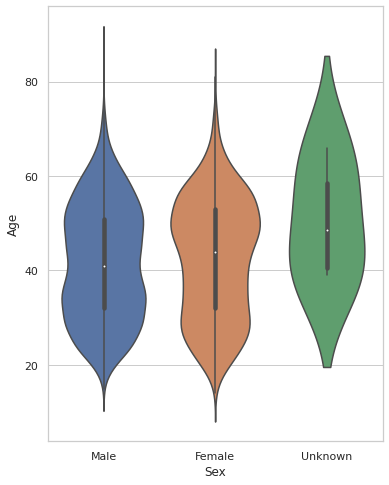

In [55]:
ax = sns.violinplot(x='Sex', y='Age', data=df, order=['Male','Female','Unknown'])

The distributions are very similar, suggesting that sex does not play a significant role in the age at which someone may overdose within this data. We notice the same two peaks with a dip around 40 in both distributions, however the peak around 50 is more pronounced within the female class. Further, the youngest deaths were recorded in the female class, whilst the oldest occured within the male class.



Let us now take a look at the youngest and oldest deaths for each drug using a scatterplot, we first define a function `rand_jitter` to introduce some random displacement of the values, this will prevent some points from completely overlapping others.

In [0]:
def rand_jitter(values):
    jitter = .02*(max(values)-min(values))
    return values + np.random.randn(len(values)) * jitter

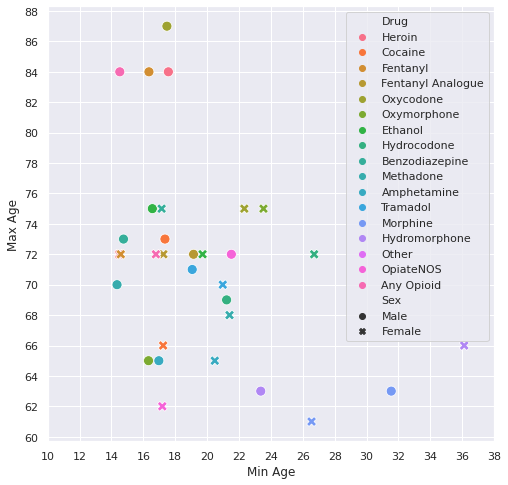

In [57]:
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.scatterplot(x=rand_jitter(df_death_sex_split['Min Age']), 
                     y=df_death_sex_split['Max Age'], 
                     hue=df_death_sex_split['Drug'], 
                     style=df_death_sex_split['Sex'], 
                      s=100)
ax.set_xticks(np.arange(10,40,2))
ax.set_yticks(np.arange(60,90,2))
plt.show()

The youngest death in the dataset was two 14 year old females overdosing on heroin and fentanyl, whilst the oldest death in the dataset was an 87 year old male overdosing on Oxycodone. We also see that the oldest deaths of males are noticeably older than females, whilst both genders populate the younger ages.

The smallest range in ages occur within the male morphine class and the female hydromorphone class at the bottom right of the scatterplot, with both classes having significantly higher minimum death ages compared to other drugs. This is likely due to the fact both morphine and hydromorphone are strong prescription medications not commonly found on the streets, making it more difficult for teenagers to obtain. Whilst the younger minimum ages occur within more well known street drugs like heroin, cocaine and benzodiazipines. The largest range in ages occur within the top left of the scatterplot, with drugs such as heroin and oxycodone.  

The above is reinforced when looking at the total deaths for each of those drugs again, the more popular drugs have lower minimum death ages compared to the less popular drugs.

Another interesting investigation surrounds the overdoses ages by county, let us plot those below using violin charts again.

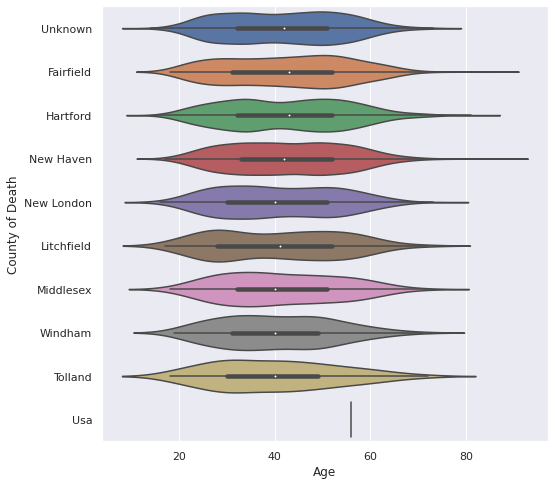

In [58]:
sns.set(rc={'figure.figsize':(8,8)}, style='whitegrid')

ax = sns.violinplot(x='Age', y='County of Death', data=df)

Woops, looks like there is another issue in the data, 'Usa' is not an American county, so let us that single cell's county to 'Unknown'.

In [0]:
df.loc[df['County of Death']=='Usa', 'County of Death'] = 'Unknown' 

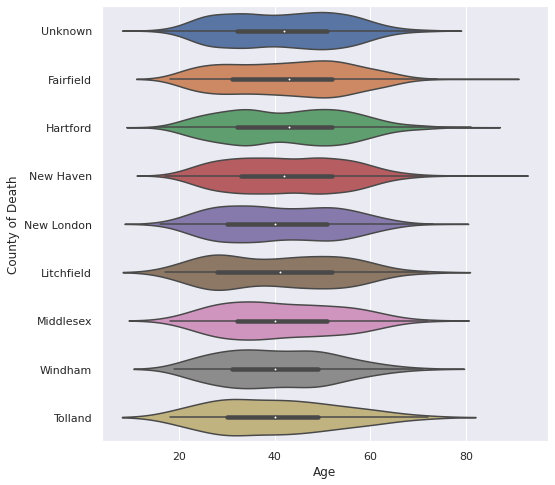

In [60]:
ax = sns.violinplot(x='Age', y='County of Death', data=df)

We can see the countys all have very similar distributions, with their means lining up almost in a row. The only exception is the max values for 3 of the countys are a bit higher than the other. This makes sense though, a person over the age of 80 overdosing is almost certainly an outlier and is unlikely to happen often.

Let us now look at the number of deaths by year, do some years have significantly higher overdoses than others? Is the drug problem getting better or worse with time? A line chart can easily answer those question.

In [0]:
# Extract the year from date column using regex
years = df['Date'].str.extract(r'[0-9]{2}\/[0-9]{2}\/([0-9]{4})', expand=False)

In [0]:
# Sort years and store deaths 
sorted_years = list(sorted(years.value_counts().index))
deaths_per_year = [years.value_counts()[year] for year in sorted_years]

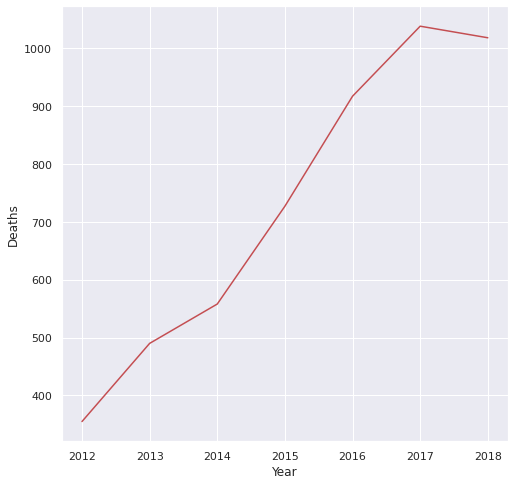

In [90]:
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.lineplot(x=sorted_years, y=deaths_per_year, color='r')
ax.set(xlabel='Year', ylabel='Deaths')
plt.show()

Woah, the above line tells a bleak story, the number of deaths have more than doubled over the first 6 years, with only a small difference between 2017 and 2018. I wonder if this trend is consistent within the Male and Female classes...

In [0]:
year_frame = df.copy(deep=True)

In [0]:
year_frame['Date'] = years

In [0]:
year_list = []
death_year_list = [] # M/F
sex_year_list = []

# Capture all relevant data
for year in sorted(years.unique()):
  year_list.extend([year]*2)
  death_year_list.extend([
    len(year_frame[(year_frame['Date']==str(year)) & (year_frame['Sex']=='Male')]),
    len(year_frame[(year_frame['Date']==str(year)) & (year_frame['Sex']=='Female')]),
  ])
  sex_year_list.extend(['Male', 'Female'])

In [0]:
# Build new dataframe from data to plot
death_by_year_sex_frame = pd.DataFrame({'Year': year_list,
                                        'Sex': sex_year_list,
                                        'Deaths' : death_year_list})

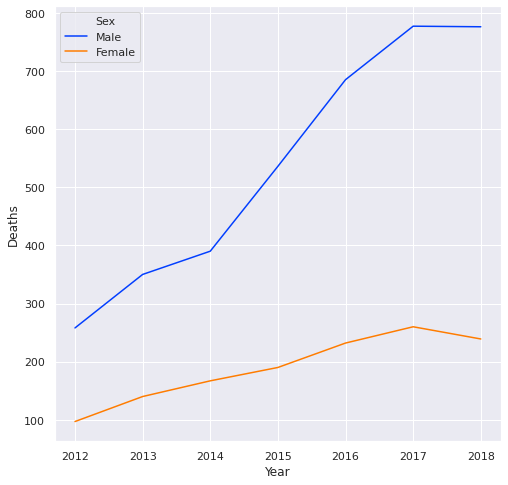

In [115]:
ax = sns.lineplot(x='Year', y='Deaths', hue='Sex', data=death_by_year_sex_frame,
                  palette='bright')

We can see that the total growth in the number of overdoses is highest in males. However, their relative growths are similar with the female class growing by ~150% whilst the male class grew by ~200%. Let us see if this increase is consistent across all countys.

In [120]:
year_list = []
death_year_list = [] # Per county
county_list = []

total_countys = len(df['County of Death'].unique())

# Capture all relevant data
for year in sorted(years.unique()):
  year_list.extend([year]*total_countys)
  for county in sorted(df['County of Death'].unique()):
    county_list.append(county)
    death_year_list.extend([
      len(year_frame[(year_frame['Date']==str(year)) & (year_frame['County of Death']==county)])
    ])

ERROR! Session/line number was not unique in database. History logging moved to new session 67


In [0]:
county_death_by_year_frame = pd.DataFrame({
    'Year':year_list,
    'County':county_list,
    'Deaths':death_year_list
})

In [0]:
no_unknowns = county_death_by_year_frame[county_death_by_year_frame['County']!='Unknown']

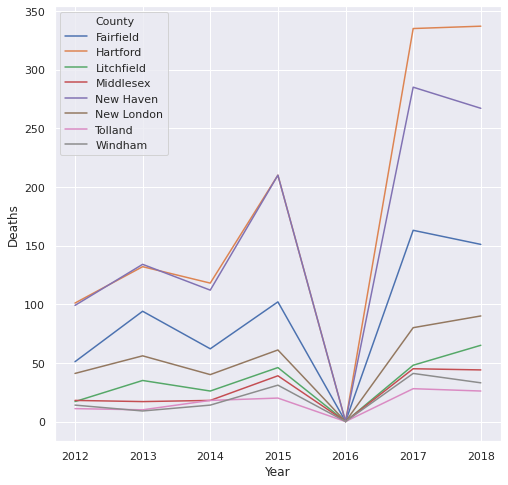

In [128]:
ax = sns.lineplot(x='Year', y='Deaths', hue='County', data=no_unknowns)

This appears strange, why is there a sudden drop in the number of deaths in the year 2016, we saw an increase above for every year but the last, so where did those values go? Since we removed the unknowns, let us plot it again with the unknown values present.

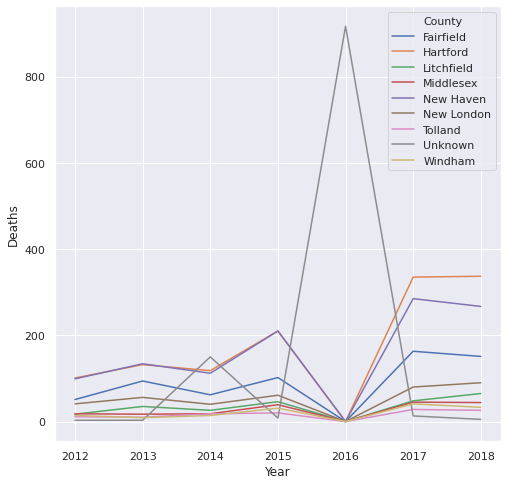

In [124]:
ax = sns.lineplot(x='Year', y='Deaths', hue='County', data=county_death_by_year_frame)

That makes a lot more sense, it wasn't that there were significantly fewer deaths in 2016, it was that the countys in which the overdoses resulted in were not reported. Interesting that this problem was almost exclusively present in the year 2016.

Next, we will determine whether the distribution of ages are similar for each year.

[Text(0, 0.5, 'Age'), Text(0.5, 0, 'Year')]

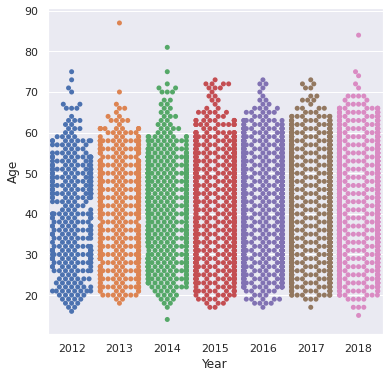

In [172]:
ax = sns.swarmplot(x='Date',y='Age',data=year_frame)
ax.set(xlabel='Year', ylabel='Age')

The ages per year are all very similar, except for the outliers. This indicates the generations abusing drugs are not changing much through the years, there are just more people abusing drugs overall as we move through the years.

Let us now look at the location frequency of deaths.

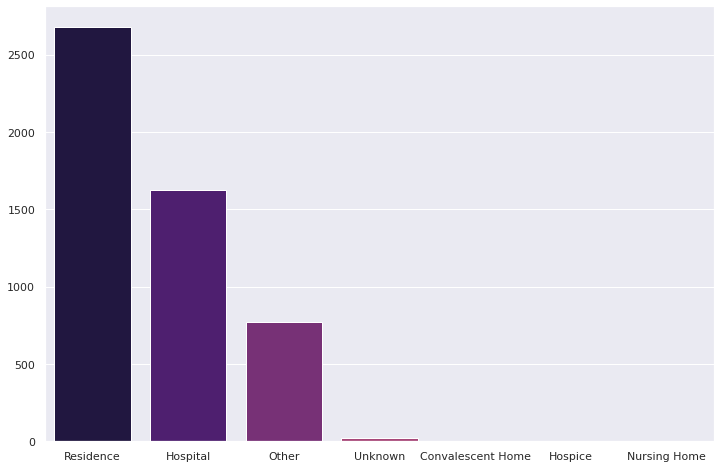

In [140]:
death_locations = list(df['Location'].value_counts().index)
deaths_per_location = list(df['Location'].value_counts())

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=death_locations, y=deaths_per_location, palette='magma')

Most people died in their residence, followed by a hospital, this is expected though. Most people abusing drugs are doing so in their houses, or end up overdosing and dying in a hospital.

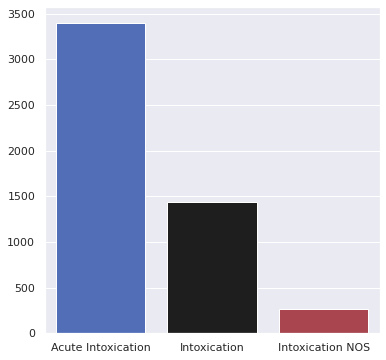

In [164]:
CODs = list(df['COD'].value_counts().index)
deaths_per_COD = list(df['COD'].value_counts())

sns.set(rc={'figure.figsize':(6,6)})
ax = sns.barplot(x=CODs, y=deaths_per_COD, palette='icefire')

After asking a doctor for clarification, 'Acute Intoxication' is the result of taking too much at once, whilst 'Intoxication' is the result of complications due to sustained use. The above makes sense in light of this, one would suspect most overdoses are the result of taking too much at once.